# Neural Network

## Load Data

In [1]:
from timeit import default_timer as timer
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np
import tensorflow as tf

In [2]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 7:
Image - Min Value: 17 Max Value: 221
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


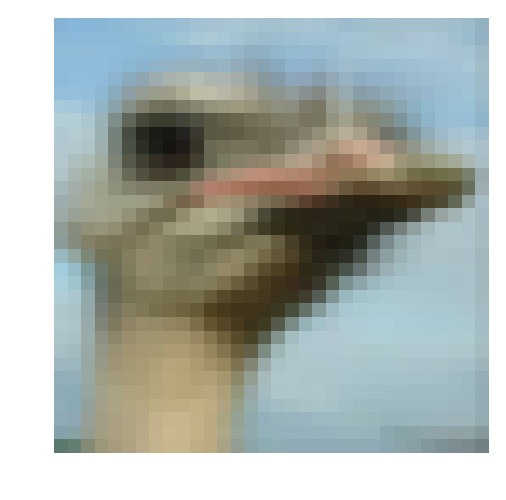

In [3]:
# Explore the dataset
batch_id = 4
sample_id = 7
batch_size = 5
image_sizes = 32
image_channels = 3
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Preprocess Data

In [4]:
def normalize(x):
    x_min = np.min(x)
    return (x - x_min)/(np.max(x) - x_min)

def one_hot_encode(x):
    encoder = tf.one_hot(x, 10)
    encodings = None
    with tf.Session() as sess:
        encodings = sess.run(encoder)
    return encodings

In [35]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Check Point

In [4]:
import pickle
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build Netwrok

In [5]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

In [6]:
def leaky_relu(x, alpha):
    return tf.maximum(x * alpha, x)

def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    tmp1 = scale * tf.nn.elu(x)
    tmp2 = scale * alpha * (tf.nn.elu(-1*tf.nn.relu(-1*x)))
    return tmp1 + tmp2

In [7]:
class Network(object):
    
    def __init__(self, l1_kernel=3, l1_depth=128, l2_kernel=3, l2_depth=64):
        self.l1_kernel = l1_kernel
        self.l1_depth = l1_depth
        self.l2_kernel = l2_kernel
        self.l2_depth = l2_depth
        # Inputs
        self.x, self.y, self.keep_prob, self.learning_rate = self.init_placeholders((32, 32, 3), 10)
        # Model
        logits = self.build()
        # Name logits Tensor, so that is can be loaded from disk after training
        logits = tf.identity(logits, name='logits')
        # Loss and Optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=self.y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        # Accuracy
        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(self.y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    def init_placeholders(self, image_shape, n_classes):
        height, width, depth = image_shape
        x = tf.placeholder(tf.float32, [None, height, width, depth], name='x')
        y = tf.placeholder(tf.float32, [None, n_classes], name='y')
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        learning_rate = tf.placeholder(tf.float32, name='learning_rate')
        return x, y, keep_prob, learning_rate

    def build(self):
        l1 = tf.layers.conv2d(self.x, self.l1_depth, kernel_size=self.l1_kernel, strides=2, padding='same')
        l1_act = selu(l1)
        l1_drop = tf.nn.dropout(l1_act, keep_prob=self.keep_prob)

        l2 = tf.layers.conv2d(l1_drop, self.l2_depth, kernel_size=self.l2_kernel, strides=2, padding='same')
        l2_act = selu(l2)
        l2_drop = tf.nn.dropout(l2_act, keep_prob=self.keep_prob)

        l3 = tf.layers.conv2d(l2_drop, 64, 3, padding='same')
        l3_act = selu(l3)

        lfc = tf.reshape(l3_act, (-1, 8*8*64))

        logits = tf.layers.dense(lfc, 10)
        return logits

In [8]:
def print_stats(session, net, total_epochs, epoch, batch_i, feature_batch, label_batch):
    train_loss = session.run(net.cost, feed_dict={net.x:feature_batch, net.y:label_batch, net.keep_prob:1.})
    valid_loss = session.run(net.cost, feed_dict={net.x:valid_features, net.y:valid_labels, net.keep_prob:1.})
    train_accuracy = session.run(net.accuracy, feed_dict={net.x:feature_batch, net.y:label_batch, net.keep_prob:1.})
    valid_accuracy = session.run(net.accuracy, feed_dict={net.x:valid_features, net.y:valid_labels, net.keep_prob:1.})
    print('Epoch {:>2}/{:>2}, CIFAR-10 Batch {} | Train Acc: {:1.2} Loss: {:1.3} | Valid Acc: {:1.2} Loss: {:1.3}'.format(
        epoch, total_epochs, batch_i, train_accuracy, train_loss, valid_accuracy, valid_loss), end='\r')

# Genetic Algorithm

In [9]:
import numpy as np
from operator import attrgetter
import string
import random

In [10]:
__DEBUG__ = False

In [15]:
class Individual(object):
    
    def __init__(self, generation, gene=None):
        self.gene = gene
        self.score = -1
        self.evaluation_time = 0.0
        self.generation = generation
        
        # define genotypes
        self.genotype_batch = [16, 32, 64, 92, 128, 256]
        self.genotype_learning_rate = [.01, .02, .03, .05, .001, .002, .003, .005, .0001, .0002, .0003, .0005]
        self.genotype_keep_probab = [.4, .5, .6, .7, .8, .9, .95, .98]
        self.genotype_conv2d_l1_kernel = [3, 5, 7]
        self.genotype_conv2d_l1_depth = [32, 64, 92, 128, 256, 512]
        self.genotype_conv2d_l2_kernel = [3, 5, 7]
        self.genotype_conv2d_l2_depth = [32, 64, 92, 128, 256, 512]
        
        # define penalties
        self.loss_mult = .1
        self.accuracy_mult = 3
        self.accuracy_delta_mult = 5
        self.penalty = 99999
        
        self.network_epochs = 5
        self.max_time = 30
        
        if gene == None:
            self.gene_length = 0
        else:
            self.gene_length = len(self.gene)
        
    def generate(self):
        self.gene = []
        self.gene.append(random.choice(self.genotype_batch))
        self.gene.append(random.choice(self.genotype_learning_rate))
        self.gene.append(random.choice(self.genotype_keep_probab))
        self.gene.append(random.choice(self.genotype_conv2d_l1_kernel))
        self.gene.append(random.choice(self.genotype_conv2d_l1_depth))
        self.gene.append(random.choice(self.genotype_conv2d_l2_kernel))
        self.gene.append(random.choice(self.genotype_conv2d_l2_depth))
        self.gene_length = len(self.gene)
        
    def fitness(self):
        self.score = 0
        
        if __DEBUG__:
            self.evaluation_time = np.random.random_sample()
            self.score = np.random.random_sample() + self.evaluation_time
            return
        
        try:
            tf.reset_default_graph()
            with tf.Session() as sess:
                start = timer()
                
                batch_size = self.gene[0]
                learning_rate = self.gene[1]
                keep_probability = self.gene[2]
                
                net = Network(l1_kernel=self.gene[3], 
                              l1_depth=self.gene[4],
                              l2_kernel=self.gene[5], 
                              l2_depth=self.gene[6])
                
                # Initializing the variables
                sess.run(tf.global_variables_initializer())
                
                # Training cycle
                for epoch in range(self.network_epochs):
                    # Loop over all batches
                    n_batches = 1
                    for batch_i in range(1, n_batches + 1):
                        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                            fd = {net.x:batch_features, 
                                  net.y:batch_labels, 
                                  net.keep_prob:keep_probability, 
                                  net.learning_rate:learning_rate}
                            sess.run(net.optimizer, feed_dict=fd)
                        print_stats(sess, net, self.network_epochs, epoch + 1, batch_i, batch_features, batch_labels)
                
                end = timer()
                self.evaluation_time = end - start
                
                train_loss = sess.run(net.cost, feed_dict={net.x:batch_features, net.y:batch_labels, net.keep_prob:1.})
                valid_loss = sess.run(net.cost, feed_dict={net.x:valid_features, net.y:valid_labels, net.keep_prob:1.})
                train_accuracy = sess.run(net.accuracy, feed_dict={net.x:batch_features, net.y:batch_labels, net.keep_prob:1.})
                valid_accuracy = sess.run(net.accuracy, feed_dict={net.x:valid_features, net.y:valid_labels, net.keep_prob:1.})

                self.score = (self.evaluation_time / 10) \
                    + train_loss*self.loss_mult \
                    + valid_loss*self.loss_mult \
                    + (1-train_accuracy)*self.accuracy_mult \
                    + (1-valid_accuracy)*self.accuracy_mult \
                    + np.abs(train_accuracy-valid_accuracy)*self.accuracy_delta_mult
        except:
            self.score = self.penalty
            return

    def cross_over(self, parent):
        cross_over_point = len(self.gene) // 2
        child = []
        for i in range(0, cross_over_point):
            child.append(self.gene[i])
        for i in range(cross_over_point, self.gene_length):
            child.append(parent.gene[i])
        return Individual(generation=self.generation, gene=child)
        
    def mutate(self, mutation_rate=0.01):
        for i in range(self.gene_length):
            prob = np.random.random_sample()
            if prob > mutation_rate:
                continue
            if i == 0:
                # batch
                val = np.random.randint(10, 101)
                self.gene[0] += val
            elif i == 1:
                # learning rate
                val = np.random.random()
                scale = np.random.randint(0, 5)
                self.gene[1] = val*(1/pow(10, scale))
            elif i == 2:
                # keep probability
                val = np.random.random()
                self.gene[2] = val
            elif i == 3:
                # conv2d l1 kernel
                val = np.random.randint(1, 3)
                self.gene[3] += val
            elif i == 4:
                # conv2d l1 depth
                val = np.random.randint(2, 17)
                self.gene[4] += val
            elif i == 5:
                # conv2d l2 kernel
                val = np.random.randint(1, 3)
                self.gene[5] += val
            elif i == 6:
                # conv2d l2 depth
                val = np.random.randint(2, 17)
                self.gene[6] += val
            else:
                raise NotImplementedError('Unknown genotype')


In [12]:
class Population(object):
    
    def __init__(self,
                 initial_population=200, 
                 max_generations=1000,
                 mutation_rate=0.01, 
                 population_diversity_threshold=10.0,
                 elitism=True,
                 tournament_size=4,
                 solution_threshold=0.0):
        self.initial_population = initial_population
        self.max_generations = max_generations
        self.mutation_rate = mutation_rate
        self.population_diversity = 0.0
        self.population_diversity_threshold = population_diversity_threshold
        self.elitism = elitism
        self.tournament_size = tournament_size
        self.solution_threshold = solution_threshold
        self.time_elapsed = 0.0
        self.global_best_individual = None
        self.global_best_solution = 88888
        self.current_best_individual = None
        self.current_best_solution = 88888
        self.generation = 0
        self.population = []
        
    def _evaluate_fitnesses_(self):
        population_length = len(self.population)
        self.population_diversity = 0.0
        for i, p in enumerate(self.population):
            if p.score < 0:
                p.fitness()
                self.time_elapsed += p.evaluation_time
            print('{}/{}, Gene {}, Score {}, Time {}'.format(i+1, 
                                                             population_length, 
                                                             p.gene, 
                                                             p.score,
                                                             p.evaluation_time))
            j = 0
            while j != i and j < range(population_length):
                self.population_diversity += np.linalg.norm(p.gene-self.population[j].gene)
                j += 1
        
        self.current_best_individual = self.evaluate_current_best_individual()
        self.current_best_solution = self.current_best_individual.score
        if self.global_best_individual == None or self.global_best_solution > self.current_best_solution:
            self.global_best_individual = self.current_best_individual
            self.global_best_solution = self.current_best_solution

    def _perform_tournament_selection_(self):
        tournament = Population()
        tournament.generation = self.generation
        for _ in range(self.tournament_size):
            i = random.choice(self.population)
            tournament.add_individual(i)
        return tournament.evaluate_current_best_individual()
    
    def generate(self):
        assert self.initial_population > 0
        self.population = [Individual(generation=self.generation) for _ in range(self.initial_population)]
        self.max_population_diversity = pow(len(self.population), 2)*len(population[0].gene)
        for p in self.population:
            p.generate()
    
    def evolve_generation(self):
        children_genes = []
        self._evaluate_fitnesses_()  
        
        if self.elitism:
            children_genes.append(self.current_best_individual)
            
        for _ in range(self.initial_population):
            # perform selection
            male = self._perform_tournament_selection_()
            female = self._perform_tournament_selection_()
            # perform cross-over
            new_individual = male.cross_over(female)
            new_individual.generation = self.generation
            # perform mutation
            if self.population_diversity <= self.population_diversity_threshold:
                new_individual.mutate(.2)
            else:
                new_individual.mutate(self.mutation_rate)
            children_genes.append(new_individual)
            
        self.population = children_genes
        self.generation += 1
            
    def evaluate_current_best_individual(self):
        return min(self.population, key=attrgetter('score'))
    
    def found_solution(self):
        return self.global_best_solution <= self.solution_threshold
    
    def add_individual(self, individual):
        self.population.append(individual)
    
    def print_score(self):
        if self.generation == 0:
            return
        print('Generation: {}/{}, Time {:2.2}s, Solution score: {}, Individual: {}'.format(
            self.generation, 
            self.max_generations,
            self.global_best_individual.evaluation_time,
            self.global_best_solution,
            self.global_best_individual.gene))    

In [13]:
# hypter-parameters
max_generations = 30
population_size = 50
mutation_rate = 0.05

In [14]:
def execute(max_generations, population_size, mutation_rate, display_interval=1):
    population = Population(population_size, max_generations)
    population.generate()
    while not population.found_solution() and population.generation < max_generations:
        population.evolve_generation()
        if population.generation % display_interval == 0:
            population.print_score()
    best_individual = population.global_best_individual
    print('\nCompleted {} generations:\nFinal score: {}, Final result: {} Generation: {}'.format(
        population.generation, 
        best_individual.score, 
        best_individual.gene,
        best_individual.generation))

In [16]:
execute(max_generations, population_size, mutation_rate)

1/50, Gene [92, 0.02, 0.98, 7, 128, 7, 256], Score 15.959331884571068, Time 20.67851063199987
2/50, Gene [128, 0.03, 0.9, 5, 64, 5, 92], Score 26.98128490274808, Time 7.31624863800016105e+02
3/50, Gene [16, 0.0005, 0.7, 3, 512, 5, 92], Score 99999, Time 0.0
4/50, Gene [64, 0.003, 0.8, 3, 256, 3, 128], Score 5.696430123896334, Time 16.156018505999782
5/50, Gene [64, 0.0005, 0.9, 5, 92, 5, 32], Score 4.357309220774096, Time 7.861257180999928
6/50, Gene [16, 0.005, 0.5, 3, 92, 7, 32], Score 11.987732164166028, Time 11.94555191299969
7/50, Gene [128, 0.001, 0.8, 7, 32, 3, 92], Score 4.438666628587862, Time 5.1481196760000785
8/50, Gene [64, 0.0003, 0.9, 3, 64, 7, 128], Score 4.444947133954065, Time 9.193014726000001
9/50, Gene [128, 0.002, 0.98, 7, 64, 7, 64], Score 4.950214907500277, Time 7.494144052000138
10/50, Gene [16, 0.0001, 0.8, 7, 92, 3, 256], Score 5.233366789377442, Time 13.734123011000065
11/50, Gene [92, 0.01, 0.95, 3, 256, 5, 92], Score 20.282707386769335, Time 17.84526162900

38/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 92], Score 4.102478418465216, Time 5.682126857000185
39/51, Gene [16, 0.003, 0.8, 5, 92, 5, 32], Score 9.524881557338905, Time 11.015898503000244
40/51, Gene [16, 0.0001, 0.8, 5, 92, 5, 32], Score 4.8960623273475905, Time 10.837459931000012
41/51, Gene [64, 0.002, 0.9, 5, 64, 7, 32], Score 4.726066822171925, Time 6.801443640000798
42/51, Gene [92, 0.02, 0.98, 7, 92, 3, 92], Score 14.836527163774008, Time 8.124678710999433
43/51, Gene [64, 0.002, 0.9, 7, 64, 3, 256], Score 5.26400596693411, Time 9.181001623000157
44/51, Gene [16, 0.0001, 0.8, 7, 64, 7, 64], Score 4.7549985382041084, Time 10.734394762000193
45/51, Gene [64, 0.0005, 0.9, 5, 92, 5, 32], Score 4.5509755760577715, Time 7.734329492000143
46/51, Gene [16, 0.005, 0.6, 7, 32, 3, 101], Score 11.058671894880717, Time 8.456008347000534
47/51, Gene [128, 0.002, 0.98, 3, 92, 3, 92], Score 4.720094284662446, Time 7.846526059000098
48/51, Gene [64, 0.0005, 0.4, 7, 92, 5, 128], Score 5.18422745072

21/51, Gene [64, 0.001, 0.4, 3, 92, 7, 64], Score 4.983119386854741, Time 9.14077383699987
22/51, Gene [128, 0.001, 0.8, 3, 64, 3, 64], Score 4.247010603504168, Time 6.004348069000116
23/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 92], Score 4.115198744138342, Time 5.537292250000064
24/51, Gene [95, 0.0005, 0.9, 3, 64, 3, 79], Score 4.260360805537493, Time 6.569781584999873
25/51, Gene [64, 0.0005, 0.9, 5, 64, 7, 42], Score 4.3836797605399624, Time 7.4457748040003935
26/51, Gene [95, 0.0005, 0.9, 7, 32, 3, 92], Score 4.2536326607048975, Time 5.291997988999356
27/51, Gene [95, 0.0005, 0.9, 7, 32, 3, 98], Score 4.100316021909111, Time 5.357313732999501
28/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 92], Score 4.219926241590838, Time 5.439077054999871
29/51, Gene [128, 0.0003, 0.4, 7, 32, 3, 92], Score 4.647790701672784, Time 5.100800827000057
30/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 92], Score 4.115310191685239, Time 5.385443564000525
31/51, Gene [128, 0.0003, 0.4, 7, 32, 3, 92], Score 4.41618152959208

4/51, Gene [64, 0.0003, 0.9, 3, 64, 3, 64], Score 4.174284870417159, Time 6.321056196999962
5/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 79], Score 4.190061254189914, Time 6.648588844999722
6/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 92], Score 4.0362649689504, Time 5.364971051999419
7/51, Gene [64, 0.0003, 0.9, 3, 64, 3, 64], Score 4.489526303081311, Time 6.335362746999635
8/51, Gene [64, 0.0003, 0.9, 7, 32, 3, 92], Score 4.180435661343836, Time 5.435182133000126
9/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 92], Score 4.107428938181874, Time 5.417433440999957
10/51, Gene [64, 0.0005, 0.9, 9, 32, 3, 92], Score 4.385891603420623, Time 5.50319825600036
11/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.086407842755852, Time 6.401409054999931
12/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 92], Score 4.391493353788246, Time 5.645396088999405
13/51, Gene [64, 0.0005, 0.9, 5, 64, 3, 64], Score 4.221171094993224, Time 6.764677187000416
14/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.26647228069678, Time 6.691

40/51, Gene [64, 0.0003, 0.9, 7, 32, 3, 92], Score 4.20188541629368, Time 5.563617728000281
41/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 92], Score 4.0375597593660135, Time 5.533671614999548
42/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 92], Score 4.148960549420463, Time 5.56573624199973
43/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.116562798553969, Time 6.476434856000196
44/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 98], Score 4.056974720921607, Time 5.662259935999828
45/51, Gene [64, 0.0003, 0.9, 7, 32, 3, 92], Score 4.2144645958404, Time 5.757575540999824
46/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.232235193278211, Time 6.411464453000008
47/51, Gene [95, 0.0005, 0.9, 7, 32, 3, 98], Score 4.2469115885995965, Time 5.471895489000417
48/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.1649715416952855, Time 6.458953970000039
49/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 98], Score 4.120622006582925, Time 5.667516505000094
50/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 98], Score 4.142657227262771, T

23/51, Gene [64, 0.0005, 0.9, 7, 32, 5, 98], Score 4.224843341954147, Time 6.0635982240000885
24/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.17849550095998, Time 6.494758114000433
25/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 98], Score 4.213793513824657, Time 5.655643559000055
26/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.130486208346065, Time 6.4287397279995275
27/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 92], Score 4.14634796486298, Time 5.862368475000039
28/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 98], Score 4.076042226194749, Time 6.2100266539991935
29/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.330128409715963, Time 6.995044373000383
30/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.221011650615219, Time 6.840442658000029
31/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.3057729567699425, Time 6.565122451000207
32/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.346377774974553, Time 6.62980434200017
33/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.136197309901581,

6/51, Gene [64, 0.0005, 0.9, 7, 39, 3, 92], Score 4.208503201902113, Time 5.851937446000193
7/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 100], Score 4.0820964683590315, Time 5.533501257000353
8/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.147664991099009, Time 6.3213881560004666
9/51, Gene [95, 0.0005, 0.9, 3, 64, 3, 64], Score 4.186350433863754, Time 6.065417456999967
10/51, Gene [64, 0.0005, 0.9, 5, 64, 3, 64], Score 4.191628356142883, Time 6.385343744000238
11/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.054908716498903, Time 6.310485242000141
12/51, Gene [64, 0.6295830359758257, 0.9, 3, 64, 3, 64], Score 240.57470210255153, Time 6.2206793190007375
13/51, Gene [95, 0.0005, 0.9, 3, 64, 3, 64], Score 4.096042100148679, Time 6.0821552629995494
14/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 98], Score 4.095934719918842, Time 5.4984380709993275
15/51, Gene [64, 0.0005, 0.9, 9, 32, 3, 98], Score 4.113825182193068, Time 5.6540933060005045
16/51, Gene [95, 0.0005, 0.9, 3, 64, 3, 64], Score 4.1

41/51, Gene [64, 0.0005, 0.9, 7, 39, 3, 92], Score 4.140760847718684, Time 5.984655706000012
42/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.171290363233856, Time 6.743628276999516
43/51, Gene [64, 0.0005, 0.9, 7, 39, 3, 92], Score 4.227771431553355, Time 5.956950966000477
44/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 100], Score 4.076613083854317, Time 5.559167061001062
45/51, Gene [95, 0.0005, 0.9, 7, 32, 3, 100], Score 4.121396998747514, Time 5.374872129999858
46/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 67], Score 4.0372737754110855, Time 6.501391041998431
47/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 100], Score 4.066001938232693, Time 5.507042630999422
48/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.127365781797562, Time 6.349162717000581
49/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.117059655205594, Time 6.314118457001314
50/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 98], Score 4.01570332303163, Time 5.519578958999773
51/51, Gene [95, 0.0005, 0.9, 3, 64, 3, 64], Score 4.14897387177261

24/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 98], Score 4.0585697979435285, Time 5.532685965999917
25/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 100], Score 4.083662510989052, Time 5.5829974520002
26/51, Gene [95, 0.0005, 0.9, 3, 64, 3, 64], Score 4.019470083980741, Time 6.102844836999793
27/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.167007931481021, Time 6.3957408309997845
28/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 98], Score 4.177163395151183, Time 5.456301658001394
29/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.173865198159911, Time 6.331475487000716
30/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.1210504988330285, Time 6.342699865001123
31/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 67], Score 4.1509309341712655, Time 6.520965029998479
32/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.0931970244660985, Time 6.257805114999428
33/51, Gene [95, 0.0005, 0.9, 7, 32, 3, 98], Score 4.037915962177794, Time 5.335413508000784
34/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.2058500703256

7/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.0935914719766515, Time 6.343237961000341
8/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.226831567092086, Time 6.263671276999958
9/51, Gene [95, 0.0005, 0.9, 7, 32, 3, 98], Score 4.0908085045755795, Time 5.329424199999266
10/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.088470327468531, Time 6.316222187000676
11/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 98], Score 4.1118647034250895, Time 5.537431295000715
12/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 98], Score 4.223568083084865, Time 5.517027748001055
13/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.286288682673512, Time 6.284888427000624
14/51, Gene [95, 0.0005, 0.9, 3, 64, 3, 64], Score 4.430615633908383, Time 6.099904241000331
15/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.090167493157241, Time 6.305656498001554
16/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.337379921645516, Time 6.321184766000442
17/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.055871404172467, 

42/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.294327276508374, Time 6.340531166000801
43/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.031247825620267, Time 6.227559638000457
44/51, Gene [95, 0.0005, 0.9, 3, 64, 3, 64], Score 4.209930765880199, Time 6.092465284000355
45/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 67], Score 4.2579729662917085, Time 6.497360692999791
46/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 98], Score 4.011002218364775, Time 5.512986417999855
47/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.183705972779171, Time 6.396084777001306
48/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 100], Score 4.313976924346025, Time 5.496718095999313
49/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.206873528318465, Time 6.337604563999776
50/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 100], Score 4.394653216227016, Time 5.5816536269994685
51/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.237205689754774, Time 6.32507222500135
Generation: 17/30, Time 6.2s, Solution score: 3.9373417976712517, I

25/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 100], Score 4.091541228131609, Time 5.603470300000481
26/51, Gene [64, 0.0005, 0.9, 3, 79, 3, 67], Score 4.153875486773723, Time 7.189526127998761
27/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.089088286889091, Time 6.224724907999189
28/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.002753835734074, Time 6.1593994480008405
29/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 67], Score 4.092370471957111, Time 6.527787899998657
30/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.090967314503177, Time 6.324459007000769
31/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 67], Score 4.108538815169413, Time 6.501592484999492
32/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.1732029546219565, Time 6.219119656998373
33/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.182390634315562, Time 6.269594113999119
34/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.194419294556246, Time 6.332903802000146
35/51, Gene [64, 0.0005, 0.9, 7, 46, 3, 100], Score 4.2750223910716

8/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.19816510362034, Time 6.75264772599985
9/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.228855059056332, Time 6.353915309000513
10/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 98], Score 4.117624597543909, Time 5.588118719999329
11/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 67], Score 4.055024347582185, Time 6.51754567900025
12/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.115827826008354, Time 6.319208536000588
13/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.128546896812987, Time 6.425578983999003
14/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.295143870955689, Time 6.209467335998852
15/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.2438220292626285, Time 6.318840653000734
16/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.208263399967473, Time 6.281420616000105
17/51, Gene [64, 0.0005, 0.9, 3, 70, 4, 64], Score 4.249978355559688, Time 6.801144877999832
18/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.073689235113671, Time

43/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 67], Score 4.156057548148783, Time 6.681224104000648
44/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.083406763631683, Time 6.30424826700073
45/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.194195560440676, Time 6.473082342001362
46/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.132313078818879, Time 6.342695535999155
47/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 3.979099870003483, Time 6.346024515998579
48/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 100], Score 4.076127966587774, Time 5.622347556998648
49/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.065084944341288, Time 6.164454442001443
50/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.09990526405345, Time 6.328695293999772
51/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.1942242579580125, Time 6.3128900100000465
Generation: 22/30, Time 6.2s, Solution score: 3.9373417976712517, Individual: [64, 0.0005, 0.9, 3, 64, 3, 64]
1/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 3.

26/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.267611694620973, Time 6.263347867001357
27/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 100], Score 4.0403153395731355, Time 5.575560545999906
28/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 100], Score 4.035254692552189, Time 5.57638477799992
29/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.466585575252429, Time 6.374104486998476
30/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.1362314618816525, Time 6.30874077199951
31/51, Gene [64, 0.0005, 0.9, 7, 32, 3, 100], Score 4.104303885877016, Time 5.569112552999286
32/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 78], Score 4.189070478507529, Time 6.634243880000213
33/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.173926816118365, Time 6.454956509000112
34/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.027462280673535, Time 6.3973753539994505
35/51, Gene [64, 0.0005, 0.8676458312539659, 3, 64, 3, 78], Score 4.292652171974259, Time 6.753541292000591
36/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 

9/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.014280525697541, Time 6.244350114000554
10/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.009722141449311, Time 6.197745839999698
11/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.064327007191423, Time 6.260951456000839
12/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.0572789928011845, Time 6.340059896998355
13/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.153609570769549, Time 6.424961417000304
14/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.110155237169056, Time 6.430702809999275
15/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.073725979581468, Time 6.287607124000715
16/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.145207201815538, Time 6.431165689000409
17/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.283066594434786, Time 6.338258383999346
18/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.19820002802553, Time 6.476140189999569
19/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.215670580048209, T

44/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.291212780675778, Time 6.399670435999724
45/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.08766214268544, Time 6.40824800900009
46/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.189325395259948, Time 6.298379808999016
47/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.203003764049936, Time 6.329400896000152
48/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 75], Score 4.224165007100055, Time 6.772687044000122
49/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.162157268929877, Time 6.42275817799964
50/51, Gene [106, 0.0005, 0.9, 3, 64, 4, 64], Score 4.1402977401274255, Time 5.938509995001368
51/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 3.928446728234485, Time 6.287473382999451
Generation: 27/30, Time 6.3s, Solution score: 3.928446728234485, Individual: [64, 0.0005, 0.9, 3, 64, 4, 64]
1/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 3.928446728234485, Time 6.287473382999451
2/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.1773

27/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.241854252489975, Time 6.314727923001556
28/51, Gene [64, 0.0005, 0.9, 3, 79, 3, 64], Score 4.224183836614247, Time 7.095393210998736
29/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 3.9587251878849203, Time 6.279632784000569
30/51, Gene [64, 0.0005, 0.9, 3, 72, 4, 64], Score 4.36319522034064, Time 6.656144178999966
31/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.175644280021333, Time 6.318988814999102
32/51, Gene [64, 0.17086140669602035, 0.9, 3, 64, 3, 64], Score 51.26478300570562, Time 6.405297923000035
33/51, Gene [64, 0.0005, 0.9, 7, 38, 3, 100], Score 4.246712569207739, Time 6.110431708999386
34/51, Gene [64, 0.0005, 0.9, 3, 64, 3, 64], Score 4.236895114133949, Time 6.420952259999467
35/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.1729524769540145, Time 6.2816567800000485
36/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.155741701378611, Time 6.270910957000524
37/51, Gene [64, 0.0005, 0.9, 3, 64, 4, 64], Score 4.0

## Train Network

In [26]:
tf.reset_default_graph()

# 92, 0.002, 0.8, 3, 64, 3, 32
# 256, 0.003, 0.6, 3, 92, 5, 64
# 64, 0.0005, 0.9, 3, 64, 4, 64
epochs = 10
batch_size = 64
learning_rate = 0.0005
keep_probability = .9
l1_kernel = 3
l1_depth = 64
l2_kernel = 4
l2_depth = 64

In [27]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    net = Network(l1_kernel=l1_kernel, 
                  l1_depth=l1_depth, 
                  l2_kernel=l2_kernel, 
                  l2_depth=l2_depth)
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                fd = {net.x:batch_features, net.y:batch_labels, net.keep_prob:keep_probability, net.learning_rate:learning_rate}
                sess.run(net.optimizer, feed_dict=fd)
            print_stats(sess, net, epochs, epoch + 1, batch_i, batch_features, batch_labels)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...


## Test Model

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.6319665605095541



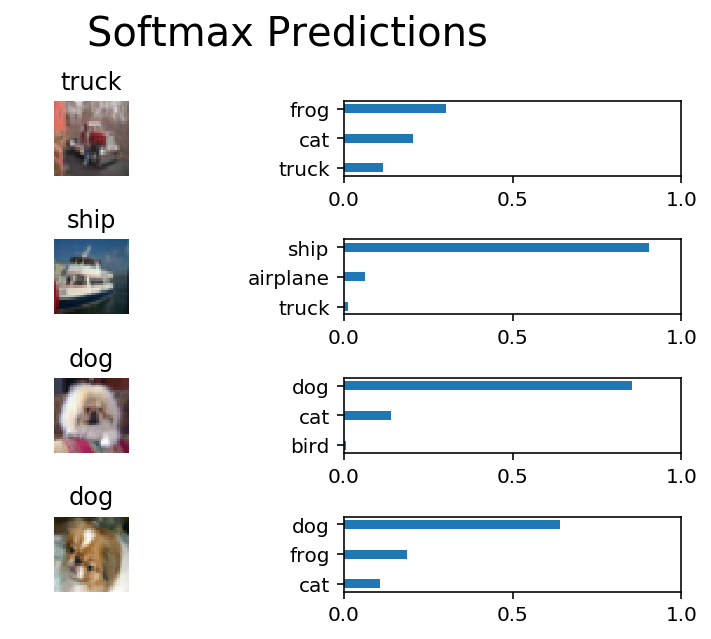

In [29]:
# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()